# Рассмотрим задачу поиска мошенничества с кредитными картами

![Fraud](imgs/fraud.jpg)

### Dataset скачиваем отсюда - https://www.kaggle.com/dalpozz/creditcardfraud/data
#### Пример решения задачи - https://www.kaggle.com/matheusfacure/semi-supervised-anomaly-detection-survey
#### Другие примеры решения задачи - https://www.kaggle.com/dalpozz/creditcardfraud/kernels

-------

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix
import itertools
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

In [2]:
# Helper functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
# Load data
dataset = pd.read_csv('data/creditcard.csv')

dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)

normal = (dataset['Class'] == 0).sum()
fraud = (dataset['Class'] == 1).sum()

print('Normal transactions: {}'.format(normal))
print('Fraud transactions: {}'.format(fraud))
print('% of fraud = {:.4f}'.format(100 * fraud / (normal + fraud)) + ' its less than < 1%')

Normal transactions: 284315
Fraud transactions: 492
% of fraud = 0.1727 its less than < 1%


In [6]:
normal = dataset[dataset['Class'] == 0]
train, valid = train_test_split(normal, test_size=.2, random_state=42)
valid, test = train_test_split(valid, test_size=.8, random_state=42)

fraud = dataset[dataset['Class'] == 1]
valid_fr, test_fr = train_test_split(fraud, test_size=.8, random_state=42)

train = train.reset_index(drop=True)
valid = valid.append(valid_fr).reset_index(drop=True)
test = test.append(test_fr).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion of anomaly in training set: %.4f\n' % train['Class'].mean())

print('Valid shape: ', valid.shape)
print('Proportion of anomaly in validation set: %.4f\n' % valid['Class'].mean())

print('Test shape:, ', test.shape)
print('Proportion of anomaly in test set: %.4f\n' % test['Class'].mean())

Train shape:  (227452, 31)
Proportion of anomaly in training set: 0.0000

Valid shape:  (11470, 31)
Proportion of anomaly in validation set: 0.0085

Test shape:,  (45885, 31)
Proportion of anomaly in test set: 0.0086



------
## Соберем автоэнкодер в Tensorflow

In [7]:
import tensorflow as tf

/Users/kovalenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [20]:
tf.reset_default_graph()
tf.set_random_seed(2)

In [21]:
batch_size = 10000

n_visible = train.drop('Class', axis=1).values.shape[1]
n_hidden1 = 27
n_hidden2 = 16
n_hidden3 = 2

learning_rate = 0.01

In [22]:
# Placehoder node - Input for data
X_tf = tf.placeholder("float", [None, n_visible], name='X')

In [23]:
def autoencoder(X_tf):
    
    # encoder
    Y = tf.layers.dense(inputs=X_tf, units=n_hidden1, activation=tf.nn.tanh)
    Y = tf.layers.dense(inputs=Y, units=n_hidden2, activation=tf.nn.tanh)
    Y = tf.layers.dense(inputs=Y, units=n_hidden3, activation=tf.nn.tanh) 
    
    # decoder
    Z = tf.layers.dense(inputs=Y, units=n_hidden2, activation=tf.nn.tanh) 
    Z = tf.layers.dense(inputs=Z, units=n_hidden3, activation=tf.nn.tanh) 
    Z = tf.layers.dense(inputs=Z, units=n_visible, activation=tf.nn.tanh) 
    
    return Z, Y

In [24]:
Z, Y = autoencoder(X_tf)

cost = tf.reduce_mean(tf.pow(X_tf - Z, 2))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
scores = tf.abs(X_tf - Z)

In [25]:
X_train = train.drop('Class', axis=1).values
X_val_norm = valid[valid['Class'] == 0].drop('Class', axis=1).values
X_val_anorm = valid[valid['Class'] == 1].drop('Class', axis=1).values

In [26]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()

    for step in range(15001):
        
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]

        sess.run(train_op, feed_dict={X_tf: batch_data,})
        
        if (step % 3000 == 0):
            print('\nBatch loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: batch_data})))
            print('Val Norm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_norm})))
            print('Val Anorm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_anorm})))
        
    y_scores_valid, enc_val = sess.run([scores, Y], feed_dict={X_tf: valid.drop('Class', axis=1).values})
    y_scores_test, enc_test = sess.run([scores, Y], feed_dict={X_tf: test.drop('Class', axis=1).values})


Batch loss at step 0: 5.594098
Val Norm loss at step 0: 5.679502
Val Anorm loss at step 0: 31.763748

Batch loss at step 3000: 4.605597
Val Norm loss at step 3000: 4.639911
Val Anorm loss at step 3000: 31.062086

Batch loss at step 6000: 4.594372
Val Norm loss at step 6000: 4.632530
Val Anorm loss at step 6000: 31.226202

Batch loss at step 9000: 4.569778
Val Norm loss at step 9000: 4.630517
Val Anorm loss at step 9000: 31.387484

Batch loss at step 12000: 4.544206
Val Norm loss at step 12000: 4.630115
Val Anorm loss at step 12000: 31.213947

Batch loss at step 15000: 4.514188
Val Norm loss at step 15000: 4.629266
Val Anorm loss at step 15000: 31.329321


In [29]:
tresholds = np.linspace(0, 6, 100)

scores = []
for treshold in tresholds:
    y_hat = (y_scores_valid.mean(axis=1) > treshold).astype(int)
    
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)

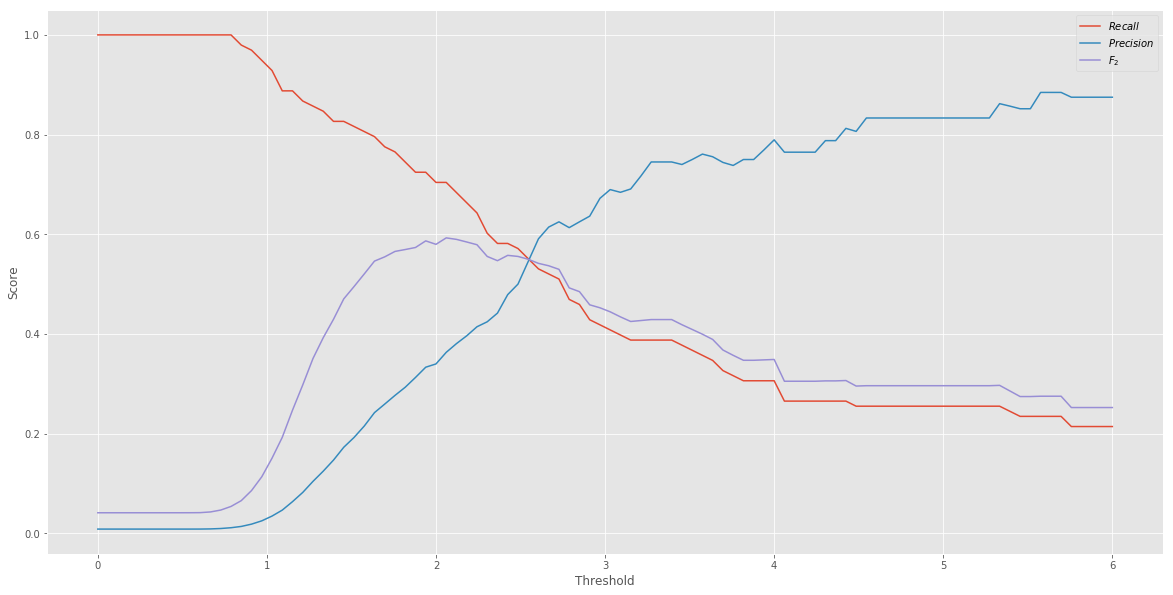

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

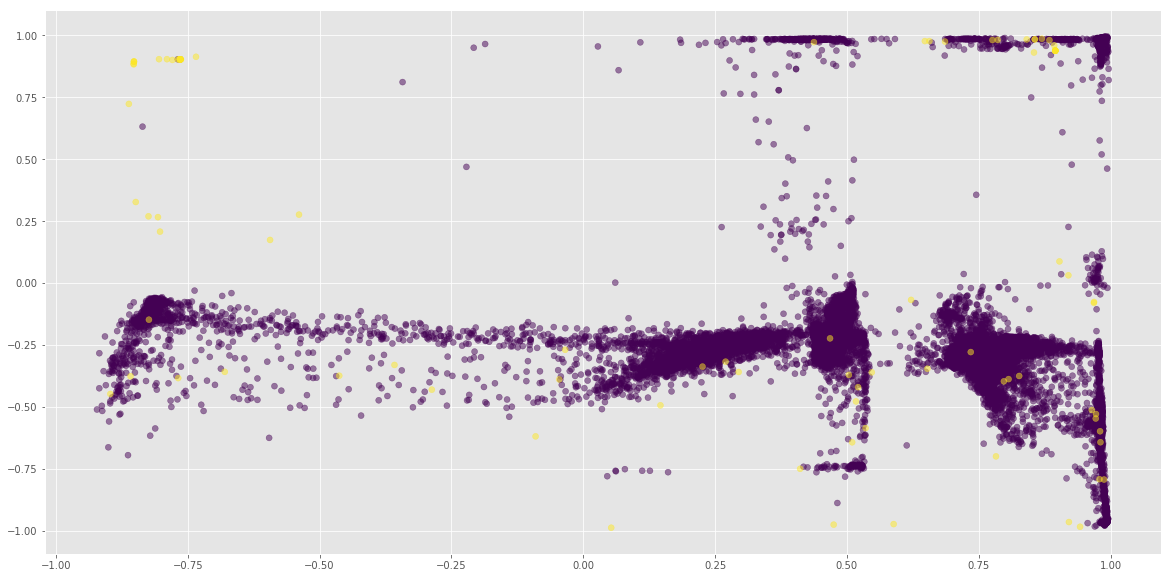

In [31]:
plt.figure(figsize=(20, 10))
plt.scatter(enc_val[:, 0], enc_val[:, 1], c=valid["Class"].values, alpha=.5)
plt.show()

Final threshold: 2.060606
Test Recall Score: 0.660
Test Precision Score: 0.331
Test F2 Score: 0.551


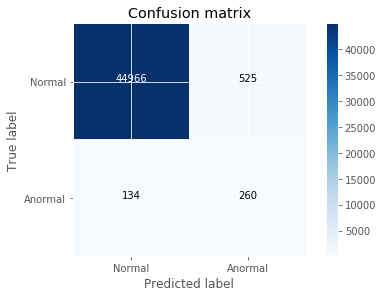

In [32]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (y_scores_test.mean(axis=1) > final_tresh).astype(int)
# print(y_hat_test.shape)
print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

--------